In [21]:
from math import pi
from itertools import batched
import pennylane as qml
import pennylane.numpy as np
from qiskit.visualization import plot_histogram
from data import labels,relations,encode_angle
from tqdm import tqdm

![graph](./assets/graph.png)

In [2]:
farest_distance = max(list(relations.values()))
print(f"Farest Distance: {farest_distance}")

Farest Distance: 9.8


In [3]:
n_qubits = len(list(relations.values())) - len(labels)
dev = qml.device('qiskit.aer', wires=n_qubits, shots=1000)

In [4]:
@qml.qnode(dev)
def model(points, weights):
    qubit_index = 0
    for key,distance in points.items():
        if(distance==0):
            continue
            
        angle = encode_angle(distance, farest_distance)
        qml.RY(angle, wires=qubit_index)
        
        qubit_index += 1
    
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_qubits), rotation=qml.RX)
    
    return qml.counts()

[{np.str_('00000001011110010110'): np.int64(1), np.str_('00000001110011101100'): np.int64(1), np.str_('00000100100010111001'): np.int64(1), np.str_('00000100100110110110'): np.int64(1), np.str_('00000101010111110100'): np.int64(1), np.str_('00000101111001011011'): np.int64(1), np.str_('00000101111101011001'): np.int64(1), np.str_('00000110001101011110'): np.int64(1), np.str_('00000110110010111000'): np.int64(1), np.str_('00000110111001110110'): np.int64(1), np.str_('00000111010010100011'): np.int64(1), np.str_('00001010000010100101'): np.int64(1), np.str_('00001100011101110001'): np.int64(1), np.str_('00001100100011110100'): np.int64(1), np.str_('00001101111100001111'): np.int64(1), np.str_('00010000000010100111'): np.int64(1), np.str_('00010000000111101001'): np.int64(1), np.str_('00010000001000001011'): np.int64(1), np.str_('00010000001001011010'): np.int64(1), np.str_('00010000001100010100'): np.int64(1), np.str_('00010000010111110010'): np.int64(1), np.str_('00010000011000001101'):

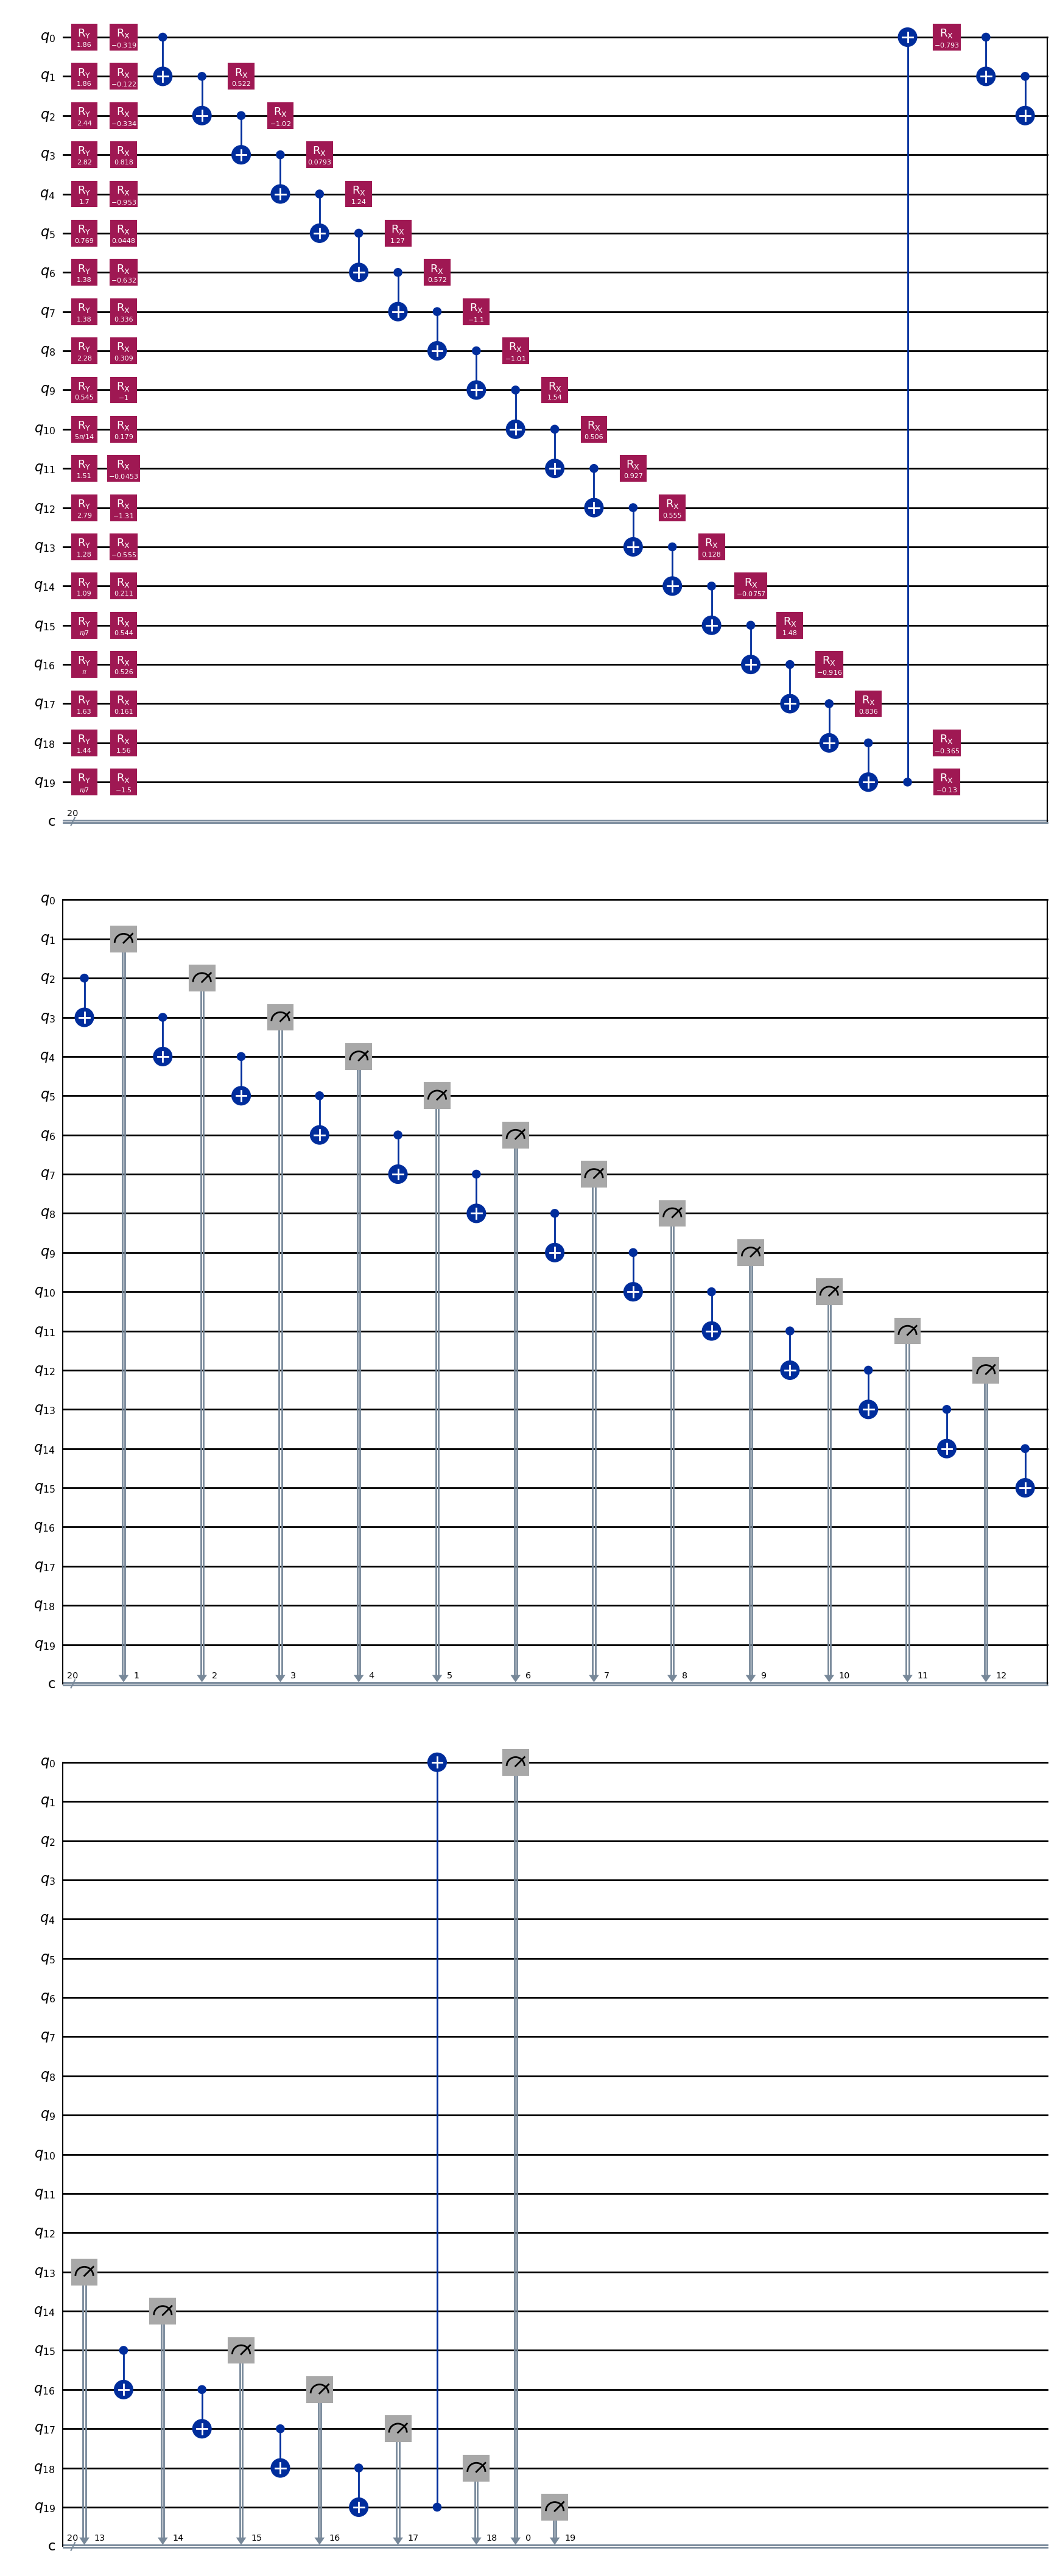

In [6]:
weights = np.random.uniform(-pi/2, pi/2, size=(1,2,n_qubits))
result = model(relations,weights)
print(result)
dev._circuit.draw('mpl')

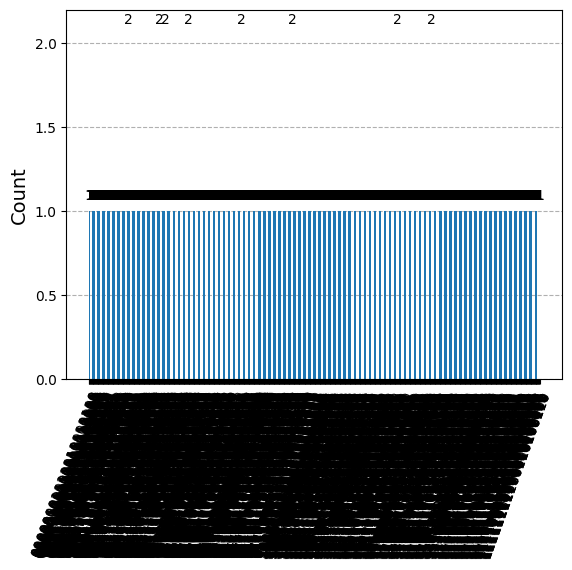

In [7]:
plot_histogram(result[0])

In [30]:
def process(data):

    values = []
    for key,total in tqdm(data.items()):

        if(total == 0):
            values.append(0)
            continue
        
        penality = 10000000000
        path_size = 0
        
        batches = list(batched(key[::-1],4))
        
        current_batch = batches[0]
        last_point = 'A'
        visited = {last_point}
        
        while len(visited) != len(labels):
            if(current_batch.count('1') > 1 or current_batch.count('0') == 4):
                values.append(penality) 
                break

            next_point = current_batch.index('1')
            next_point_label = list(labels)[next_point]

            if(next_point_label in visited):
                values.append(penality)
                break

            visited.add(next_point_label)
            current_batch = batches[next_point]
            path_size += relations[f'{last_point}{next_point_label}']
            last_point = next_point_label
        values.append(path_size) 
    return values[::-1]
            
            


In [31]:
process(result[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 992/992 [00:00<00:00, 518344.28it/s]


[0,
 10000000000,
 0,
 10000000000,
 8.8,
 10000000000,
 7.6,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 7.6,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 8.8,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 11.0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 8.8,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 7.6,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 8.8,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 10000000000,
 0,
 100000